# Variance Comparisons

The following codes generate the figures shown in my lab seminar presentation.

In [1]:
library(dplyr)
library(rstan)
library(ggplot2)
library(gridExtra)
library(xtable)

options(repr.plot.width = 10, repr.plot.height = 7)

source("bbvi_simplemix.R")


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: StanHeaders


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




## Variance Comparisons Between Naive, Rao-Blackwellized, and James-Stein Estimators

We will be performing the estimation repeatedly, to get a controlled Monte Carlo sample of the inherent variances in the estimators being compared.

**Don't Run The Next Cell Unless Updating Results**

In [6]:
all.variances <- NULL
niter <- 100
sampsize <- 200
mc_size <- 500

all_means <- -5:5
all_vars <- rep(3, times = length(all_means))

for(K in 2:10){
    d <- generate_mixture(sampsize, runif(K), means=all_means[1:K], vars=all_vars[1:K])

    phi <- t(sapply(d, function(x){
        y <- runif(K)
        return(y/sum(y))
    }))

    m <- all_means[1:K] + 1
    iters <- list(niter)
    for(i in 1:niter){
        if(i %% 50 == 0) message(paste0("Mixture Components: ", K, "; Iteration: ", i, "/", niter))
        
        dat.nav <- generate_samples(mc_size, y = d, phi = phi, m=m, ssq=all_vars[1:K], method="Naive")
        dat.rbl <- generate_samples(mc_size, y = d, phi = phi, m=m, ssq=all_vars[1:K], method="RB")
        dat.jsp <- generate_samples(mc_size, y = d, phi = phi, m=m, ssq=all_vars[1:K], method="JS+")
        dat.rbp <- generate_samples(mc_size, y = d, phi = phi, m=m, ssq=all_vars[1:K], method="RB+")

        iters[[i]] <- rbind(
            cbind(method="Naive", iter=i, generate_bbvi(dat.nav)),
            cbind(method="RB", iter=i, generate_bbvi(dat.rbl)),
            cbind(method="JS+", iter=i, generate_bbvi(dat.jsp)),
            cbind(method="RB+", iter=i, generate_bbvi(dat.rbp))
        )
    }

    mse <- do.call('rbind',iters)
    par.variances <- aggregate(mse[,4:ncol(mse)], by=list(method=mse$method, param=mse$param), var)
    for(method in c("Naive","RB","JS+","RB+")){
        this.method <- par.variances[par.variances$method == method,3:ncol(par.variances)]
        all.variances <- rbind(all.variances,
            data.frame(K=K, method=method,logVar=log(mean(as.matrix(this.method)))))
    }
}

saveRDS(all.variances, "Outputs/all_variances.RDS")
saveRDS(mse, "Outputs/last_iteration.RDS")

Mixture Components: 2; Iteration: 50/100

Mixture Components: 2; Iteration: 100/100

Mixture Components: 3; Iteration: 50/100

Mixture Components: 3; Iteration: 100/100

Mixture Components: 4; Iteration: 50/100

Mixture Components: 4; Iteration: 100/100

Mixture Components: 5; Iteration: 50/100

Mixture Components: 5; Iteration: 100/100

Mixture Components: 6; Iteration: 50/100

Mixture Components: 6; Iteration: 100/100

Mixture Components: 7; Iteration: 50/100

Mixture Components: 7; Iteration: 100/100

Mixture Components: 8; Iteration: 50/100

Mixture Components: 8; Iteration: 100/100

Mixture Components: 9; Iteration: 50/100

Mixture Components: 9; Iteration: 100/100

Mixture Components: 10; Iteration: 50/100

Mixture Components: 10; Iteration: 100/100



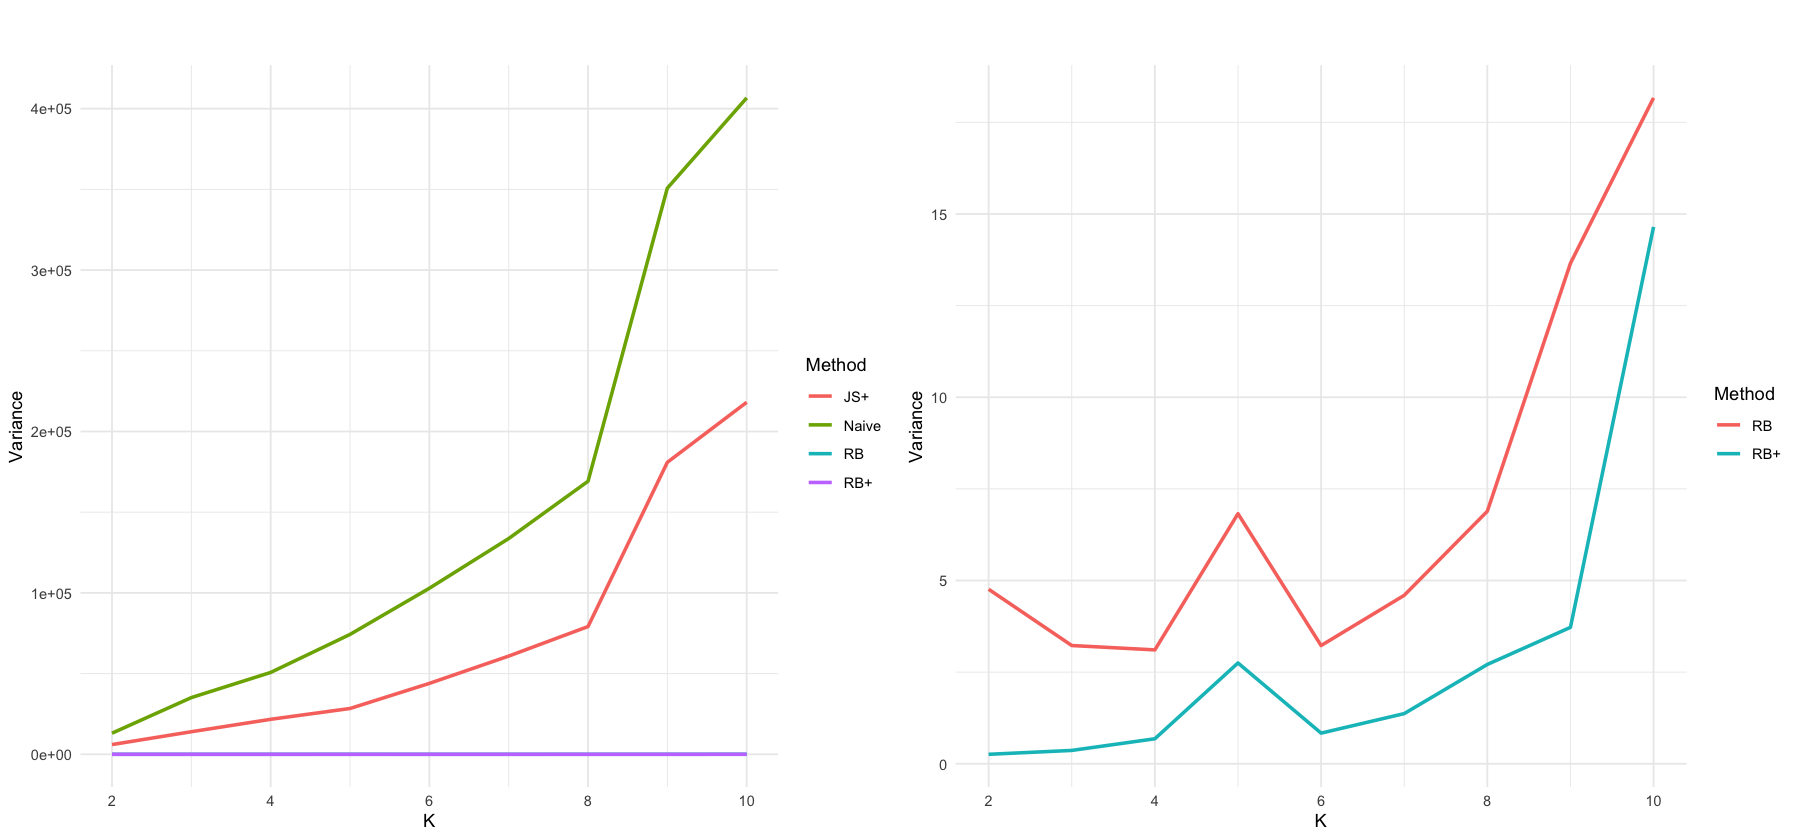

In [10]:
all.variances <- readRDS("Outputs/all_variances.RDS")

p1 <- all.variances %>%
    ggplot(aes(x=K, y=exp(logVar), color=method)) +
    geom_line(linewidth=1) + 
    labs(title = "", subtitle = "", x = "K", y = "Variance") +
    theme_grey(base_size=22) +
    scale_color_discrete(name = "Method") +
    theme_minimal()

p2 <- all.variances %>%
    filter(method %in% c("RB","RB+")) %>%
    ggplot(aes(x=K, y=exp(logVar), color=method)) +
    geom_line(linewidth=1) + 
    labs(title = "", subtitle = "", x = "K", y = "Variance") +
    theme_grey(base_size=22) +
    scale_color_discrete(name = "Method") +
    theme_minimal()

options(repr.plot.width = 15, repr.plot.height = 7)
grid.arrange(p1, p2, nrow = 1)

In [14]:
all.efficiencies <- NULL
for(k in 2:6){
    this.var <- all.variances[all.variances$K == k, ]
    this.var$Var <- exp(this.var$logVar)
    this.var$Eff <- 1
    this.var$Eff[2:4] <- 100 * this.var$Var[2:4]/this.var$Var[1]
    all.efficiencies <- rbind(all.efficiencies, this.var)
}

all.efficiencies %>%
    mutate(Var = round(Var, 2), Eff = round(Eff,2)) %>%
    select(K, method, Var, Eff)

,K,method,Var,Eff
,<int>,<chr>,<dbl>,<dbl>
1,2,Naive,13084.48,1.00
2,2,RB,4.76,0.04
3,2,JS+,6030.64,46.09
4,2,RB+,0.26,0.00
5,3,Naive,35140.99,1.00
6,3,RB,3.23,0.01
7,3,JS+,13989.01,39.81
8,3,RB+,0.36,0.00
9,4,Naive,50725.17,1.00
